In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pickle
from MoDE_embeddings.MoDE import MoDE
from sklearn.manifold import TSNE, Isomap, MDS
from MoDE_embeddings.metrics import distance_metric, correlation_metric, order_preservation, cart2pol
%load_ext autoreload
%autoreload 2

In [2]:
data = loadmat("data/small_stock.mat")["StockData"]
score = loadmat("data/small_stock.mat")["Score"]

In [3]:
#normalize
m = np.mean(data, axis=1)
data = data - m.reshape((-1,1))

s = np.max(data, axis=1) - np.min(data, axis=1)
data = data / s.reshape((-1,1))

In [4]:
data.shape

(436, 128)

In [5]:
from MoDE_embeddings.waterfilling_compression import WaterfillingCompression
comp = WaterfillingCompression()

In [6]:
start = time.time()
dm_ub, dm_lb = comp.compute_distance_bounds(data)
print(time.time() - start)

27.602384328842163


In [5]:
# for now using exact distance matrix
from sklearn.metrics import pairwise_distances
dm = pairwise_distances(data, n_jobs=-1)

In [6]:
# temporary: for now limit the decimals
dm = np.round(dm, decimals=5)
dm_ub = dm #np.round(dm_ub, decimals=5)
dm_lb = dm #np.round(dm_lb, decimals=5)

In [7]:
mode = MoDE(n_neighbor=20, max_iter=100000, tol=0.0001, verbose=True)

In [8]:
start = time.time()

x_2d_mode = mode.fit_transform(data, score.squeeze())

print("time: ", time.time() - start)

0.005747126436781609
Start of Gradient Descent algorithm
0 out of 100000 iterations has passed
10000 out of 100000 iterations has passed
20000 out of 100000 iterations has passed
GD stopped after 26000 iteration
end of GD algorithm
time:  6.941032648086548


In [11]:
dm_avg = (dm_lb + dm_ub) / 2

In [18]:
# mds
mds = MDS(dissimilarity="precomputed")
x_2d_mds = mds.fit_transform(dm_avg)

In [19]:
# ISOMAP
isomap = Isomap(n_neighbors=20, n_components=2, metric="precomputed")
x_2d_isomap = isomap.fit_transform(dm_avg)

In [20]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=6.5, n_iter=3000, verbose=1, metric="precomputed")
x_2d_tsne = tsne.fit_transform(dm_avg)

/home/ahmad/anaconda3/envs/new_MoDE/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 20 nearest neighbors...
[t-SNE] Indexed 436 samples in 0.000s...
[t-SNE] Computed neighbors for 436 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 436 / 436
[t-SNE] Mean sigma: 0.272874
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.387886
[t-SNE] KL divergence after 3000 iterations: 1.082572


In [15]:
# load parula colormap for visualization
with open("parula_colormap.pkl", "rb") as f:
    p = pickle.load(f)

from matplotlib.colors import LinearSegmentedColormap
parula_map = LinearSegmentedColormap.from_list('parula', p, N = 2252)

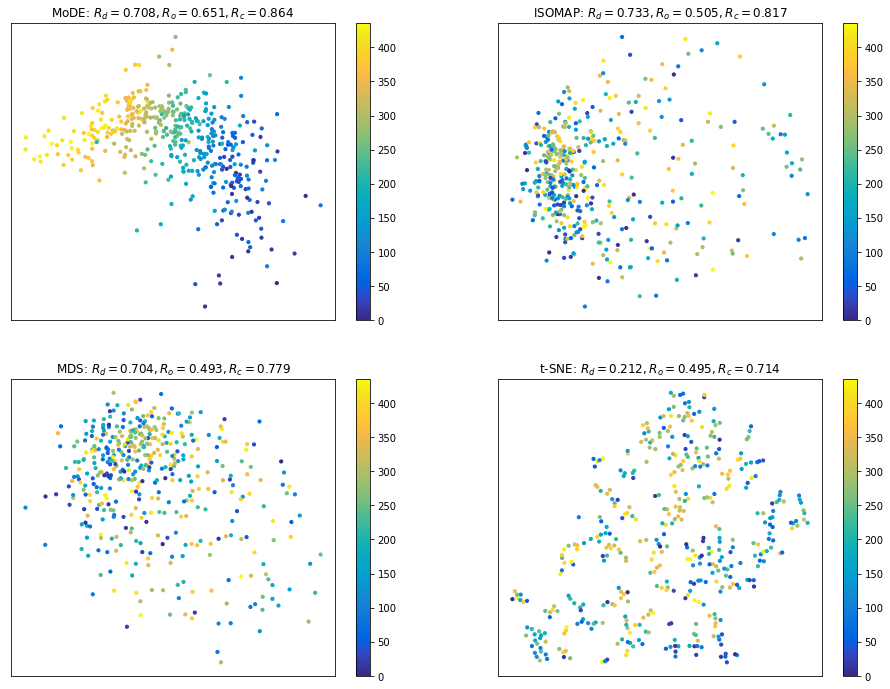

In [24]:
colors = np.argsort(np.argsort(score.squeeze()))
marker_size = 10
fig, ax = plt.subplots(2,2, figsize=(16,12))
p1 = ax[0,0].scatter(x_2d_mode[:, 0], x_2d_mode[:,1], c=colors, cmap=parula_map, s=marker_size)
R_d = distance_metric(data, x_2d_mode, n_neighbor=20)
R_c = correlation_metric(data, x_2d_mode, n_neighbor=20)
R_o = order_preservation(x_2d_mode, mode.P.squeeze(), n_neighbor=20, score=score.squeeze())
ax[0,0].set_title("MoDE: $R_d={}, R_o={}, R_c={}$".format(np.round(R_d, 3), np.round(R_o, 3), np.round(R_c, 3)))
fig.colorbar(p1, ax=ax[0,0]);

p2 = ax[0,1].scatter(x_2d_isomap[:, 0], x_2d_isomap[:,1], c=colors, cmap=parula_map, s=marker_size)
R_d = distance_metric(data, x_2d_isomap, n_neighbor=20)
R_c = correlation_metric(data, x_2d_isomap, n_neighbor=20)
isomap_angles = cart2pol(x_2d_isomap[:, 0], x_2d_isomap[:, 1])[1]
R_o = order_preservation(x_2d_isomap, isomap_angles, n_neighbor=20, score=score.squeeze())
ax[0,1].set_title("ISOMAP: $R_d={}, R_o={}, R_c={}$".format(np.round(R_d, 3), np.round(R_o, 3), np.round(R_c, 3)))
fig.colorbar(p2, ax=ax[0,1]);

p3 = ax[1,0].scatter(x_2d_mds[:, 0], x_2d_mds[:,1], c=colors, cmap=parula_map, s=marker_size)
R_d = distance_metric(data, x_2d_mds, n_neighbor=20)
R_c = correlation_metric(data, x_2d_mds, n_neighbor=20)
mds_angles = cart2pol(x_2d_mds[:, 0], x_2d_mds[:, 1])[1]
R_o = order_preservation(x_2d_mds, mds_angles, n_neighbor=20, score=score.squeeze())
ax[1,0].set_title("MDS: $R_d={}, R_o={}, R_c={}$".format(np.round(R_d, 3), np.round(R_o, 3), np.round(R_c, 3)))
fig.colorbar(p3, ax=ax[1,0]);

p4 = ax[1,1].scatter(x_2d_tsne[:, 0], x_2d_tsne[:,1], c=colors, cmap=parula_map, s=marker_size)
R_d = distance_metric(data, x_2d_tsne, n_neighbor=20)
R_c = correlation_metric(data, x_2d_tsne, n_neighbor=20)
tsne_angles = cart2pol(x_2d_tsne[:, 0], x_2d_tsne[:, 1])[1]
R_o = order_preservation(x_2d_tsne, tsne_angles, n_neighbor=20, score=score.squeeze())
ax[1,1].set_title("t-SNE: $R_d={}, R_o={}, R_c={}$".format(np.round(R_d, 3), np.round(R_o, 3), np.round(R_c, 3)))
fig.colorbar(p4, ax=ax[1,1]);
# remove the x and y ticks
for a in ax.reshape((-1)):
    a.set_xticks([])
    a.set_yticks([])
# plt.savefig("figures/ESG.jpg", dpi=1200);
plt.show();